In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import imutils
import random
import pandas as pd

import os.path
from os import path

from google.colab import files

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras.regularizers import l2

from scipy.stats import mode

from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle


import h5py

import json
import time
import itertools
import seaborn as sns


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
FOLDER_PATH = '/content/drive/My Drive/Boggle/' #path to Boggle folder in Google Drive

In [ ]:
def ij_to_index(i,j, board_size):
    ''' 
    i: x index of board
    j: y index of board
    board_size: board size
    
    returns index of i,jth cell in 1d array
    '''
    return i * board_size + j

In [ ]:
def index_to_i_j(index, board_size):
    '''
    index: index in 1d array of board
    board_size: board size
    
    returns i,j coordinates of index in 1d array
    '''
    row = index//board_size
    col = index%board_size
    return row, col

In [ ]:
class trie_node:
    def __init__(self, value):
        self.value = value
        self.children = {}
        self.parent = None
        self.word = False

In [ ]:
def make_trie_from_words(words):
    '''
    words: list of words from dictionary with punctuation stripped
    
    returns root node of created trie
    '''
    t1 = time.time()
    root = trie_node(None)
    
    for word in words:
        current_node = root # restart from top of trie with new word

        for letter in word:
            if not letter in current_node.children: # add new prefix to trie
                new_node = trie_node(letter)
                new_node.parent = current_node

                current_node.children[letter] = new_node
                current_node = new_node

            else:
                current_node = current_node.children[letter] # advance current node down trie
        current_node.word = True
    print("Trie creation took", round(time.time()-t1), 'seconds')
    return root

In [ ]:
def create_trie(level, minimum_word_length):
    '''
    level: size of SCOWL dictionary
    minimum_word_length: threshold for valid words in boggle game
    
    returns root node of trie
    '''

    if level in ['10', '20', '35', '40', '50','55','60', '70', '80','95']:
        filename = FOLDER_PATH + 'Dictionaries/SCOWL_'+level+'.txt'
        with open(filename) as fh:
            final_content = fh.readlines()
            final_content = [i.rstrip().lower() for i in final_content if len(i.rstrip())>=minimum_word_length and "\'" not in i]
        print()
        print('Dictionary has ',len(final_content),'words')
        trie = make_trie_from_words(final_content)
        return trie
    
    else:
        print('level must be one of 10, 20,35,40,50,55,60,70, 80,95')
        return None

In [ ]:
def check(word, trie):
    '''
    word: word to be checked against in trie
    trie: trie to search for word in 
    
    returns status of word in trie
    '''
    current_node = trie
    for letter in word:       
        if letter in current_node.children: # advance current node
            current_node = current_node.children[letter]
        else:
            return 'neither' # word is not in dictionary trie
    
    if current_node.word and len(current_node.children) > 0: # node is both a word and a prefix for more words
        return'wordandprefix'
    elif current_node.word and len(current_node.children) == 0: # node is just a word -> no further words
        return 'word'
    elif not current_node.word and len(current_node.children) > 0:# node is a prefix but not a word
        return 'prefix'

In [ ]:
def get_all_possible_words_from_board(board, trie, board_size):
    
    checked_words =0
    words = []
    
    queue = []
    for i in range(board_size):
        for j in range(board_size):
            queue.append((i, j, board[i][j], [ij_to_index(i,j, board_size)])) # initialize queue with one entry per letter in initial boad
    
    while len(queue)>0:
        curr_element = queue.pop(0)
        
        cur_i = curr_element[0]
        cur_j = curr_element[1]
        visited_indices = curr_element[3]
      
        for i_offset in range(-1, 2): 
            for j_offset in range(-1, 2): # checks all neighboring squares
                updated_i = cur_i + i_offset
                updated_j = cur_j + j_offset
                
                index = ij_to_index(updated_i, updated_j, board_size)
                
                if 0 <= updated_i < board_size and 0 <= updated_j < board_size and not index in visited_indices:# neighbor must be within board boundary and not already used in word
                    neighbor = str(board[updated_i][updated_j])  
                    if neighbor != '':
                        new_potential_word = curr_element[2] + neighbor
                        typ = check(new_potential_word, trie)
                        if typ == 'word':
                            words.append(new_potential_word)
                        if typ == 'prefix' or typ == 'wordandprefix':
                            new_visited_indices = visited_indices + [index]
                            queue.append((updated_i, updated_j, new_potential_word, new_visited_indices))

                        checked_words +=1
    print()
    print(checked_words,'potential words checked')
    return words

In [ ]:
def crop_rect(img, rect):
    '''
    img: blurred image with boggle board
    rect: min area rectangle coordinates

    modified from https://jdhao.github.io/2019/02/23/crop_rotated_rectangle_opencv/
    '''
    # get the parameter of the small rectangle
    center, size, angle = rect[0], rect[1], rect[2]
    center, size = tuple(map(int, center)), tuple(map(int, size))

    # get row and col num in img
    height, width = img.shape[0], img.shape[1]

    # calculate the rotation matrix
    M = cv.getRotationMatrix2D(center, angle, 1)
    # rotate the original image
    img_rot = cv.warpAffine(img, M, (width, height))

    # now rotated rectangle becomes vertical and we crop it
    img_crop = cv.getRectSubPix(img_rot, size, center)
    return img_crop

In [ ]:
def find_boggle_square_from_picture(filename):
    '''
    filename: filename of boggle image
    returns images of edge detected and cropped board images
    '''       
    img = cv.imread(filename,0)
    resized = imutils.resize(img, width = 300) # shrink to aid blurring
    ratio = img.shape[0] / float(resized.shape[0])#save to scale up to original image for output
    high_res_edge = cv.Canny(img, 200, 400)#low threshold edge detection for saving best board

    edge_img = cv.Canny(resized, 500, 900) # high edge threshold to eliminate most non-board edges
    blur_img = cv.GaussianBlur(edge_img, (101, 101), 10)  #strong blur to create white blob around board
    
    ret,thresh = cv.threshold(blur_img,50,255,0) #low threshold to eliminate background noise
    contours,hierarchy = cv.findContours(thresh, 1, 2)
    cnt = contours[0]
    rect = cv.minAreaRect(cnt)#bounding rectangle for board
    buffer_size = 140
    center, size, angle = np.array(rect[0])*ratio, (np.array(rect[1])*ratio) + buffer_size, rect[2] # scale up to original image size and add buffer
    modified_rect = (center, size, angle)
     
    img_crop = crop_rect(img, modified_rect)
    edge_crop = crop_rect(high_res_edge, modified_rect)
  
    return edge_crop, img_crop

In [ ]:
def remove_duplicate_grids(grid_list, grid_width):
    '''
    combines overlapping grid lines into a single list of grid locations - helper function for get_grids_from_boggle_square
    grid_list: overlapping list of grid lines
    grid_width: width in pixels
    '''
    new_list = []
    #list of difference between neighboring grid lines
    diff_list = [0]+[grid_list[i+1]-grid_list[i] for i in range(len(grid_list)-1)]+[0]
   
    last_i = 0
    for i in range(len(grid_list)):
        # grid lines that should be combined are close together
        if diff_list[i] > 3 * grid_width:
            new_list.append(int(np.median(grid_list[last_i:i]))) #take final grid line as median of combined grid lines
            last_i =i
    new_list.append(int(np.median(grid_list[last_i:])))
            
    return new_list

In [ ]:
def get_grids_from_boggle_square(edges, grid_width):
    '''
    takes in edges array and grid width and returns the lists of x and y cuts to segment letters
    edges: 2d array of edge detected image
    grid_wdith: width of grid to divide on 
    
    '''
    vert_values = [] # sum of pixels in vertical gridline
    
    for i in range(0, edges.shape[0]-grid_width+1):
        grid_value = np.sum(edges[:, i:i + grid_width+1])
        vert_values.append(grid_value)
    #take 20 highest scoring gridlines (contain the most edges)
    vert_cutoff = sorted(vert_values)[-20]

    horiz_values = [] # same as above for horizontal grid lines
    for i in range(0, edges.shape[1]-grid_width +1):
        grid_value = np.sum(edges[i:i + grid_width + 1, :])
        horiz_values.append(grid_value)
    horiz_cutoff = sorted(horiz_values)[-20]

    vert_grid_indices= remove_duplicate_grids(list(np.where(vert_values > vert_cutoff)[0]), grid_width)
    horiz_grid_indices = remove_duplicate_grids(list(np.where(horiz_values > horiz_cutoff)[0]), grid_width)
    
    return vert_grid_indices, horiz_grid_indices

In [ ]:
def gridify_img(img, horiz_grid_indices, vert_grid_indices):
    '''
    takes in cropped image of board and places to cut for grids, returns individual letters
    img: return from find_boggle_square_from_picture
    horiz_grid_indices, vert_grid_indices: return values from get_grids_from_boggle_square
    returns list of images of each letter
    '''
    imgs = []
    for i in range(len(horiz_grid_indices)-1):
        for j in range(len(vert_grid_indices)-1): #iterates across all divisions made by grid
            
            left_x = max(0, horiz_grid_indices[i])
            left_y = max(0, vert_grid_indices[j])
            right_x = min(img.shape[0], horiz_grid_indices[i+1])
            right_y = min(img.shape[1], vert_grid_indices[j+1])
            
            ratio = (right_x-left_x)/(right_y-left_y)
            if ratio > 0.8: #check that grid divisions should be approximately square
                grid_img = img[left_x:right_x, left_y:right_y]
                imgs.append(grid_img)
    return imgs      

In [ ]:
def standardize_images(imgs, min_x = None, min_y = None):
    '''
    imgs: list of imgs of each letter
    min_x: default none, otherwise crop to these coordinates
    min_y: default none, otherwise crop to these coordinates
    returns resized x and y coordinates and resized images
    '''
    if min_x == None or min_y == None:
        for i in imgs:
            if  min_x == None or i.shape[0]< min_x:
                min_x = i.shape[0]
            if min_y == None or i.shape[1] < min_y:
                min_y = i.shape[1]
                
    for i in range(len(imgs)):
        imgs[i] =imgs[i][:min_x, :min_y]
        
    return min_x, min_y, imgs

In [ ]:
def generate_data(imgs, labels, nsamples, params ):
    '''
    imgs: list of images to be augmented
    labels: imgs labels
    nsamples:  how many augmented images should be created from each base image
    returns training data and their labels
    '''

    training_data = []
    training_labels = []

    datagen = ImageDataGenerator(**params)
    

    for img , label in zip(imgs, labels):
        i = 0
        img = np.array(img)
        img = img.reshape(1, img.shape[0], img.shape[1], 1)
        
        training_labels +=  [label]*nsamples
        for aug in datagen.flow(img, batch_size =  1):
            aug = aug.reshape(img.shape[1],img.shape[2])
            training_data.append(aug)
            i+=1

            if i>= nsamples:
                break
  
    return np.array(training_data),np.array(training_labels)

In [ ]:
def letter_to_int(letter):
    '''
        letter: letter label with boggle value
        returns integer label
    '''
    fancy_letters = {'Qu':25,'An':26, 'Er':27, 'He':28, 'In':29,'Th':30 }
    try:
        label = fancy_letters[letter]
    except KeyError:
        label =  ord(letter)-65
        if label > 16:
            label -= 1
    return label

In [ ]:
def int_to_letter(int_label):
    '''
    int_label: integer label of a boggle square
    returns letter label
    '''
    fancy_letters = {25:'Qu',26:'An', 27:'Er', 28:'He', 29:'In',30:'Th'}
    try:
        label = fancy_letters[int_label]
    except KeyError:
        if int_label > 15:#Q letter DNE
            int_label +=1
        label = chr(int_label + 65)
    return label

In [ ]:
def board_from_prediction(int_list):
    '''
    takes list of predicted integer classes, maps to letter value and returns 2d array of board
    '''
    board_size = int(np.sqrt(len(int_list)))
    letter_list = []
    for i in int_list:
        letter_list.append(int_to_letter(i).lower())
    letter_list = np.array(letter_list).reshape(board_size, board_size)
    return letter_list, board_size

In [ ]:
def baseline_model():
    global x, y
    model = Sequential()
    model.add(Conv2D(64, kernel_size = 3, activation = 'relu', input_shape = (x,y,1)))#kernel_regularizer = l2(0.0004),
    BatchNormalization()
    model.add(Conv2D(64, kernel_size = 3, activation = 'relu', input_shape = (x,y,1)))#kernel_regularizer = l2(0.0004),
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.20))
    
    model.add(Conv2D(128, kernel_size = 3, activation = 'relu', input_shape = (x,y,1)))#kernel_regularizer = l2(0.0004),
    BatchNormalization()
    model.add(Conv2D(128, kernel_size = 3, activation = 'relu', input_shape = (x,y,1))) #kernel_regularizer = l2(0.0004),
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.30))
    
    model.add(Conv2D(256, kernel_size = 3, activation = 'relu', input_shape = (x,y,1))) #kernel_regularizer = l2(0.0004),
    BatchNormalization()
    model.add(Conv2D(256, kernel_size = 3, activation = 'relu', input_shape = (x,y,1))) #kernel_regularizer = l2(0.0004),
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.40))
    
    model.add(Flatten())
    
    model.add(Dense(1024, activation = 'relu')) #,kernel_regularizer = l2(0.0004)
    model.add(Dropout(0.3))
    
    model.add(Dense(512,activation = 'relu')) #,kernel_regularizer = l2(0.0004)
    model.add(Dropout(0.2))
    
    
    model.add(Dense(31, activation = 'softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [ ]:

class ConfusionMatrixPlotter(Callback):
    """Plot the confusion matrix on a graph and update after each epoch
    # Arguments
        X_val: The input values 
        Y_val: The expected output values
        classes: The categories as a list of string names
        cmap: Specify matplotlib colour map
        title: Graph Title
        
        from https://github.com/chasingbob/keras-visuals/blob/master/visual_callbacks.py
    """
    def __init__(self, X_val, Y_val):
        self.X_val = X_val
        self.Y_val = Y_val
           
    def on_epoch_end(self, epoch, logs={}):  
        if epoch % 50 == 0:  
          pred = self.model.predict(self.X_val)
          max_pred = np.argmax(pred, axis=1)
          cnf_mat = confusion_matrix(self.Y_val, max_pred)
          print(cnf_mat)

In [ ]:
def create_cnn(training_data, training_labels, class_weights):
    training_data, training_labels = shuffle(training_data, training_labels)
    es = EarlyStopping(monitor='val_loss', mode='min', patience = 100, min_delta = 0)
    mc = ModelCheckpoint(FOLDER_PATH + '/Models/best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose = 2)
    cm = ConfusionMatrixPlotter(training_data[:100], training_labels[:100])
    estimator = KerasClassifier(build_fn=baseline_model, epochs=500, batch_size=32, verbose=0)

    history = estimator.fit(training_data[100:],training_labels[100:], validation_split = 0.2, callbacks = [es, mc, cm], shuffle = True, verbose = 0)#class_weight = class_weights,
    
    return estimator, history

In [ ]:
def update_training_data(filename, labels, grid_width):
    '''
    filename: boggle image to be added to training data
    labels: labels of boggle image as 1d array
    grid_width: width of pixels to search for boggle dice in
    '''
    current_boards = pd.read_csv(FOLDER_PATH + 'TrainingData/CurrentBoards.csv')
    current_boards = list(current_boards['CurrentBoards'])
    if filename not in current_boards:
        n_current_boards = len(current_boards)
        print('adding ', filename,' to training data')
        print('finding board in image...')
        final_resize_edges, final_resize = find_boggle_square_from_picture(filename)
        vert_grid_indices, horiz_grid_indices = get_grids_from_boggle_square(final_resize_edges, grid_width)
        print('segmenting into letters...')
        imgs = gridify_img(final_resize, horiz_grid_indices, vert_grid_indices)
        for im, l in zip(imgs,labels):
            path_to_img_file = FOLDER_PATH + 'TrainingData/'+int_to_letter(l) + str(n_current_boards) + '.png'
            cv.imwrite(path_to_img_file, im)
        current_boards.append(filename)
        pd.DataFrame(current_boards, columns = ['CurrentBoards']).to_csv(FOLDER_PATH + 'TrainingData/CurrentBoards.csv', index = False)

In [ ]:
x = None
y = None

def train_cnn(training_data_size):  
    '''
    training_data_size: number of image alterations to make for each base training image
    returns trained cnn, final training data, andhistory of training metrics
    '''
    global x, y
    print('Loading Base Training Data')
    imgs = []
    labels = []
    # cwd = os.getcwd() 
    for filename in os.listdir(FOLDER_PATH+ 'TrainingData'):
        if filename.endswith(".png"):
            img_file = os.path.join(FOLDER_PATH + 'TrainingData/', filename)
            img = cv.imread(img_file, 0)
            img = cv.Canny(img, 200, 400)
            imgs.append(img)
            labels.append(get_label_from_filename(filename))
        else:
            continue

    print('Standardizing image size')
    x,y,imgs = standardize_images(imgs) 

    max_count = max([np.sum(np.array(labels) == i) for i in labels])
    class_weights = {i:max_count/np.sum(np.array(labels)==i) for i in labels}       

    print(class_weights)

    file_metadata_dict = {'x':x,'y':y,'n':len(imgs)}
    with open(FOLDER_PATH +'TrainingData/metadata.json', 'w') as json_file:
        json.dump(file_metadata_dict, json_file)
  
    print('generating training data ...')
    params={"rotation_range":360,          # randomly rotate image by upto 90 deg
        "width_shift_range":0.2,      # randomly shift along x 
        "height_shift_range":0.2,     # randomly shift along y
        "shear_range":0.2,            # shearing image
        "zoom_range":0.05,
        "horizontal_flip":True,       # flip along y axis
        "vertical_flip":True,
        "fill_mode":'nearest',
        "rescale":1./255}

    training_data, training_labels = generate_data(imgs, labels, training_data_size,params)
    training_data = np.array(training_data).reshape(len(training_data),x, y, 1)
    print(training_data.shape[0], 'training images generated')
    
    print('creating neural net')
    estimator, history = create_cnn(training_data, training_labels,class_weights)
    return estimator, imgs, history

In [ ]:
def get_label_from_filename(filename):
    '''
    filename: name of file from saved training images

    returns the label of given file based on its name
    '''
    label = ''
    i = 0
    curr_letter = filename[i]
    while not curr_letter.isdigit() and i < len(filename)-1:
        label += curr_letter
        i+=1
        curr_letter = filename[i] 

    return letter_to_int(label)

In [ ]:
def get_board(filename, cnn, x,y, grid_width = 4):
    '''
      filename: path to new boggle image to be classified
      cnn: trained CNN
      grid_width: width to be used to find grids in input image

      returns 2d array of board and size of board
    '''
    boggle_edges, board = find_boggle_square_from_picture(filename)
    vert_grid_indices, horiz_grid_indices = get_grids_from_boggle_square(boggle_edges, grid_width)
    imgs = gridify_img(board, horiz_grid_indices, vert_grid_indices)
    _x, _y, imgs = standardize_images(imgs, x, y)

    board_data = np.array(imgs).reshape(len(imgs), x, y, 1)
    y_pred = []

    params={"rescale":1./255}

    for letter in board_data:
        all_predictions= []
        letter = cv.Canny(letter,200, 400)
        letter, lab = generate_data([letter], [0], 1, params)
        letter= letter[0]
        letter = letter.reshape(1, x, y, 1)  
        y_pred.append(np.argmax(cnn.predict(letter, verbose = 0)[0]))
    
    board, board_size = board_from_prediction(y_pred)
    return board, board_size

In [ ]:
def plot_history(history):
    fig,ax= plt.subplots(1,1,figsize = (8,8))
    val_accuracy = history.history['val_accuracy']
    accuracy = history.history['accuracy']
    ax.plot(val_accuracy, label = 'Validation')
    ax.plot(accuracy, label = 'Train')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    plt.savefig(FOLDER_PATH + 'Accuracy.png')

    fig,ax= plt.subplots(1,1,figsize = (8,8))
    val_accuracy = history.history['val_loss']
    accuracy = history.history['loss']
    ax.plot(val_accuracy, label = 'Validation')
    ax.plot(accuracy, label = 'Train')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.savefig(FOLDER_PATH + 'Loss.png')


In [ ]:
def train():
  with open(FOLDER_PATH +'TrainingImages/labels.json') as json_file:
      label_dict = json.load(json_file)

  # cwd = os.getcwd()  
  for filename in os.listdir(FOLDER_PATH + 'TrainingImages'):
      if filename.endswith(".png") or filename.endswith(".PNG"):
          img_file = os.path.join(FOLDER_PATH + 'TrainingImages/', filename)
          try:
              label = label_dict[filename]
              int_labels = list(map(letter_to_int, label))
              update_training_data(img_file, int_labels, 4  )
          except KeyError:
              print('Please add labels for file',filename, 'to the labels.json file')
          
  cnn, images, history = train_cnn(200)
  plot_history(history)


In [ ]:
def get_test_accuracy(pred_label_dict):
    with open(FOLDER_PATH + 'TestingImages/test_labels.json') as json_file:
        label_dict = json.load(json_file)
    all_true = []
    all_pred= []
    for file in pred_label_dict:
        true = np.char.lower(label_dict[file])
        pred = np.char.lower(pred_label_dict[file])
        all_true += list(true)
        all_pred += list(pred)
    print('Accuracy:',100 * np.sum(np.array(all_true) == np.array(all_pred))/len(all_true))
    labels = sorted(list(set(all_true)))
    cm = confusion_matrix(all_true, all_pred, normalize = 'true',labels = labels)

    fig, ax= plt.subplots(1,1,figsize = (20,15))
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);



Loading Base Training Data
Standardizing image size
{0: 1.0, 1: 1.5, 2: 1.5, 3: 1.7142857142857142, 4: 1.0, 5: 1.7142857142857142, 6: 2.4, 7: 1.3333333333333333, 8: 1.0909090909090908, 9: 4.0, 10: 4.0, 11: 1.5, 12: 1.3333333333333333, 13: 1.3333333333333333, 14: 1.0909090909090908, 15: 1.3333333333333333, 25: 2.4, 16: 1.2, 17: 1.0, 18: 1.2, 20: 3.0, 21: 2.0, 22: 3.0, 23: 2.4, 24: 3.0, 19: 1.7142857142857142, 26: 6.0, 28: 6.0, 27: 12.0, 29: 12.0, 30: 12.0}
generating training data ...
41000 training images generated
creating neural net

Epoch 00001: val_loss improved from inf to 2.43011, saving model to /content/drive/My Drive/Boggle//Models/best_model.h5
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 3 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 

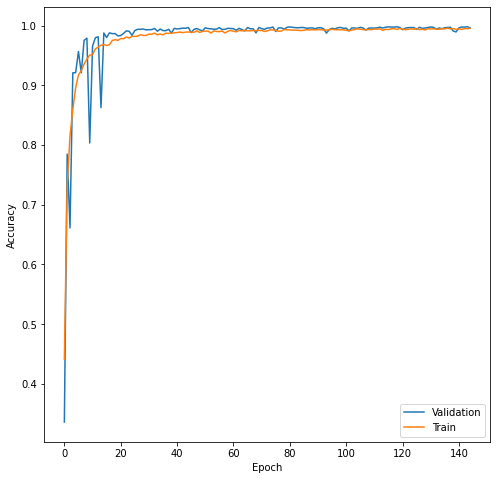

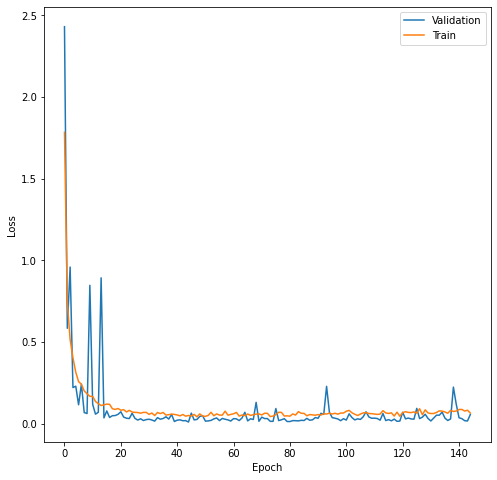

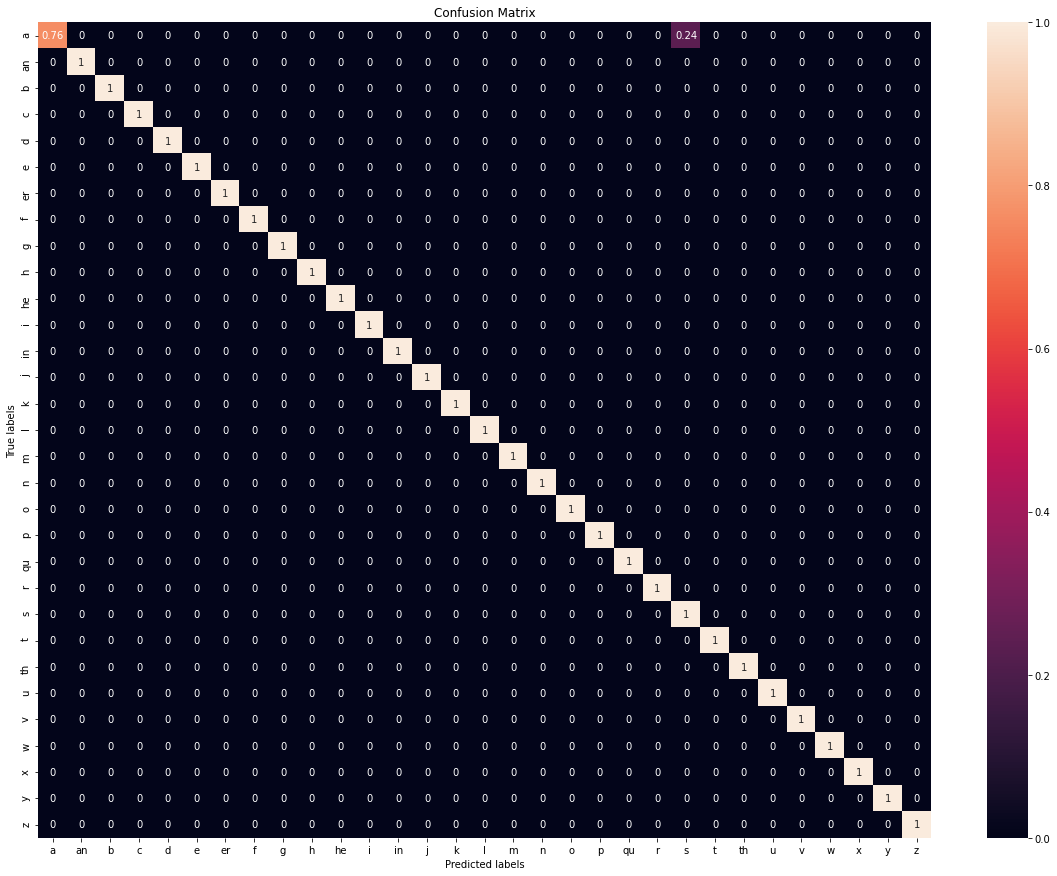

In [ ]:
train() 
cnn = load_model(FOLDER_PATH + '/Models/best_model.h5')
params= {
    'dictionary_level':'95',
    'min_word_length':4 
}
trie = create_trie(params['dictionary_level'], params['min_word_length'])
if trie == None:
    print('Trie failed to create')
else:
    with open(FOLDER_PATH +'TrainingData/metadata.json') as json_file:
        metadata_dict = json.load(json_file)
    x = metadata_dict['x']
    y = metadata_dict['y']
    
    pred_label_dict = {}

    for filename in os.listdir(FOLDER_PATH+'TestingImages'):
        if filename.endswith(".png") or filename.endswith(".PNG"):
            img_file = os.path.join(FOLDER_PATH + 'TestingImages/', filename)
            print('Filename:',img_file)
            board, board_size = get_board(img_file, cnn,x ,y, 4 )
            pred_label_dict[filename]= board.flatten()
            print('Board:')
            print(board)
            all_words = set(get_all_possible_words_from_board(board,trie, board_size))
            print(len(all_words), 'words found')
            print(list(all_words))
            print('-----------------------------------------------------------')
            print()
    get_test_accuracy(pred_label_dict)
            
      

In [6]:
for filename in os.listdir(FOLDER_PATH+ 'TrainingData'):
    if filename.endswith(".png"):
        os.remove(FOLDER_PATH + 'TrainingData/' + filename)
pd.DataFrame(data = None, columns = {"CurrentBoards"}).to_csv(FOLDER_PATH + 'TrainingData/CurrentBoards.csv')